# PyTorch Introduction with Feed-Forward Neural Networks

Here are some additional (official) tutorials to check out:
- [PyTorch Intro](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [PyTorch NLP Intro](https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html)
- [Neural Net intro in PyTorch](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py)

## Concepts covered
1. Python Introduction
2. Tensors & tensor operations
3. Create sample dataset & data loader
4. Neural network intro

In [1]:
import random
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data.dataset import random_split

# Make plots pretty
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')

In order to perform deep learning on a GPU (so that everything runs super quick!), CUDA has to be installed and configured. Fortunately, Google Colab already has this set up, but if you want to try this on your own GPU, you can [install CUDA from here](https://developer.nvidia.com/cuda-downloads). Make sure you also [install cuDNN](https://developer.nvidia.com/cudnn) for optimized performance.

In [2]:
print('GPU available?', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

GPU available? False


device(type='cpu')

## A short Python introduction

### Lists

In [3]:
people = ['Jeffrey', 'Alex', 'Susannah']

# The following is called a list comprehension
[person for person in people if 'e' in person]

['Jeffrey', 'Alex']

### Dictionaries

In [4]:
age_records = [
    ('Jeffrey', 28),
    ('Alex', 30),
    ('Susannah', 23),
]
# The following is called a dictionary comprehension
ages = {key: value for key, value in age_records}
ages

{'Jeffrey': 28, 'Alex': 30, 'Susannah': 23}

Note that we could've also created a dictionary directly the following way:
```python
ages = {
    'Jeffrey': 28,
    'Alex': 30,
    'Susannah': 23,
}
```

You can assign a key with a new value.

In [5]:
ages['Timo'] = 35
ages

{'Jeffrey': 28, 'Alex': 30, 'Susannah': 23, 'Timo': 35}

You can also delete a key.

In [6]:
del ages['Timo']
ages

{'Jeffrey': 28, 'Alex': 30, 'Susannah': 23}

Default dictionaries are also useful if you want to give keys default values.

In [7]:
people = ['Jeffrey', 'Alex', 'Susannah', 'Jeffrey', 'Alex', 'Jeffrey']

# Without default dict
people_counted_vanilla = {}
for person in people:
    if person not in people_counted_vanilla:
        people_counted_vanilla[person] = 0
    people_counted_vanilla[person] += 1

# With default dict (simpler code!)
people_counted_defaultdict = defaultdict(int)
for person in people:
    people_counted_defaultdict[person] += 1
    
# Both methods produce the same outcome, but one is simpler
assert people_counted_defaultdict == people_counted_vanilla

people_counted_defaultdict

defaultdict(int, {'Jeffrey': 3, 'Alex': 2, 'Susannah': 1})

### Pandas `DataFrame`

The `DataFrame` from the Pandas Python library makes it easy to work with tabular data. Let's load some data from a CSV file downloaded from Google Drive.

In [8]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

df = pd.read_csv(DATA_PATH)

# Use df.head() to preview the first five rows of the DataFrame
df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


You can use `df.iloc[index]` to grab the row at `index`. To access the field, you can either do `df.field` or `df['field']`.

In [9]:
df.iloc[2].review

"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like clichÃ©'e version of gangsters.<br /><br />The movie doesn't take more than five minutes to explain what is going on before we're already at the warehouse There is not a single sympathetic character in this movie, except for the homeless guy, who is also the only one with half a brain.<br /><br />Bill Paxton and William Sadler are both hill billies and Sadlers character is just as much a villain as the gangsters. I did'nt like him right from the start.<br /><br />The movie is filled with pointless violence and Walter Hills specialty: people falling through windows with glass flying everywhere. There is pretty much no plot and it is a big problem when you root for no-one. Everybody dies, except from Paxton and the homeless guy and everybody get what they deserve.<br /><br />The only two black people that can act is the 

In [10]:
df.iloc[2].label

0

You can also slice the `DataFrame` like you slice a list.

In [11]:
df.iloc[500:505]

,review,label
500,I'm not really sure where to begin. From start...,0
501,I thought i could see something good but... I ...,0
502,Sci-Fi channel thinks this IS Sci-Fi; it's a s...,0
503,"Sorry, after watching the credits, I thought t...",0
504,I knew five minutes after the monster made his...,0


You can sample the `DataFrame` to get random examples. I use this one a lot!

In [12]:
df.sample(5)

,review,label
41197,This movie strikes me as one of the most succe...,1
12378,Even if you're a fan of Jean Rollin's idiosync...,1
52634,I saw this film a while ago on a Video CD.<br ...,0
48337,This is the first movie i've seen of John Sing...,1
53596,How can anyone not love this movie ? I think i...,1


A very useful function for the `DataFrame` in Pandas is `df.apply()`. Use it to apply a function to your `DataFrame`.

In [13]:
def get_first_word(text):
    return text.split()[0]

# Create a new column called "first_word"
df['first_word'] = df.review.apply(get_first_word)
df.head()

,review,label,first_word
0,Once again Mr. Costner has dragged out a movie...,0,Once
1,This is an example of why the majority of acti...,0,This
2,"First of all I hate those moronic rappers, who...",0,First
3,Not even the Beatles could write songs everyon...,0,Not
4,Brass pictures (movies is not a fitting word f...,0,Brass


In [14]:
def first_word_and_label(row):
    return row.first_word + ', ' + str(row.label)

# Apply the function row-by-row by using axis=1
df['first_word_and_label'] = df.apply(first_word_and_label, axis=1)
df.head()

,review,label,first_word,first_word_and_label
0,Once again Mr. Costner has dragged out a movie...,0,Once,"Once, 0"
1,This is an example of why the majority of acti...,0,This,"This, 0"
2,"First of all I hate those moronic rappers, who...",0,First,"First, 0"
3,Not even the Beatles could write songs everyon...,0,Not,"Not, 0"
4,Brass pictures (movies is not a fitting word f...,0,Brass,"Brass, 0"


### Class inheritance

Methods with double underscores before and after the name are called **dunder (double under) methods**. Here are a few relevant ones:

* **`__init__(self, *args, **kwargs)`**: Runs when the class is instantiated
* **`__getitem__(self, index)`**: Returns value at index. Allows you to slice the instantiated class using square brackets
* **`__len__(self)`**: Returns the length of the instantiated class

In [15]:
class People(object):
    def __init__(self, name, height, age):
        self.name = name
        self.height = height
        self.age = age
   
    def get_age(self):
        return self.age


class Professor(People):
    def __init__(self, name, height, age, classes_taught=['statistics', 'calculus']):
        super(Professor, self).__init__(name=name, height=height, age=age)
        self.title = 'Professor'
        self.classes_taught = classes_taught
  
    def get_age(self):
        return 'always 25'


class Student(People):
    def __init__(self, name, height, age, graduation_year):
        super(Student, self).__init__(name=name, height=height, age=age)
        self.graduation_year = graduation_year

In [16]:
donald = People('Donald Trump', 180, 65)
print(donald.name, 'age is', donald.get_age())

aemon = Professor('Maester Aemon', 170, 105)
print(aemon.name, 'age is', aemon.get_age())
print(aemon.name, 'has taught', ', '.join(aemon.classes_taught))

john = Student('John Snow', 175, 20, 1265)
print(john.name, 'age is', john.get_age())
print(john.name, 'graduation year:', john.graduation_year)

Donald Trump age is 65
Maester Aemon age is always 25
Maester Aemon has taught statistics, calculus
John Snow age is 20
John Snow graduation year: 1265


## Tensors

![Tensors](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/tensors.jpg?raw=1)

Tensors come in `N` dimensions! Here are the words we use to refer to certain dimensions:
- `0-dim`: Scalar
- `1-dim`: Vector
- `2-dim`: Matrix
- `3-dim`: Cube
- `N-dim`: Higher-order tensor

### Creating Tensors

You can create a tensor sampled from a uniform distribution on interval $[0, 1)$.

In [17]:
uniform_tensor = torch.rand([3, 2, 4])
print('Shape:', uniform_tensor.shape)
uniform_tensor

Shape: torch.Size([3, 2, 4])


tensor([[[0.0336, 0.1921, 0.7162, 0.6091],
         [0.1910, 0.8648, 0.7478, 0.4181]],

        [[0.7975, 0.4829, 0.8430, 0.7298],
         [0.1653, 0.6396, 0.9698, 0.4440]],

        [[0.3861, 0.7864, 0.8927, 0.0514],
         [0.1016, 0.8577, 0.5588, 0.2581]]])

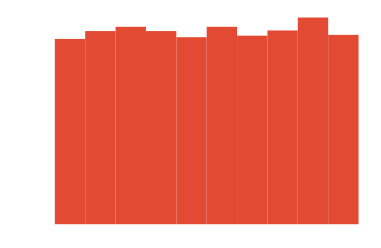

In [18]:
plt.hist(torch.rand(10000))
plt.axis('off')
plt.show()

Or you can sample from a standard normal distribution.
$$X \sim \mathcal{N}(\mu,\,\sigma^{2})$$
$$\mu = 0, \sigma^2 = 1$$

In [19]:
normal_tensor = torch.randn([3, 2, 4])
print('Shape:', normal_tensor.shape)
normal_tensor

Shape: torch.Size([3, 2, 4])


tensor([[[ 0.3563,  0.7728, -1.9649,  2.0416],
         [ 1.2262, -0.3887,  0.4670, -0.1343]],

        [[-0.4053,  0.0521, -2.1711,  0.3273],
         [ 1.1718,  1.5832,  0.4071,  0.4339]],

        [[-2.0709,  1.3422, -0.1030, -0.1077],
         [-1.1654,  0.3922, -0.5702,  0.3627]]])

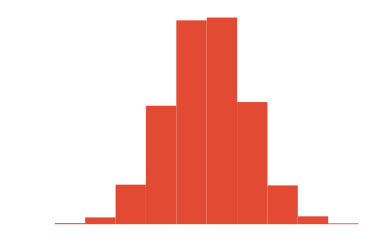

In [20]:
plt.hist(torch.randn(10000))
plt.axis('off')
plt.show()

In [21]:
# Ones
torch.ones([3, 2])

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [22]:
# Broadcast operations also work
(torch.ones([3, 2]) * 8 / 15 + 2 - 20) ** 2

tensor([[305.0845, 305.0845],
        [305.0845, 305.0845],
        [305.0845, 305.0845]])

In [23]:
# Zeros
torch.zeros([3, 2])

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [24]:
# Create a sequence tensor from a range
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [25]:
# Create a tensor from a numpy array
inputs = np.random.normal(size=5)
input_tensor = torch.FloatTensor(inputs)
input_tensor

tensor([-0.4178,  1.5353, -0.5590,  2.0238,  0.5971])

In [26]:
# Transform back to a numpy array
input_tensor.numpy()

array([-0.4177925 ,  1.5353471 , -0.55897194,  2.023783  ,  0.5970511 ],
      dtype=float32)

### Reshaping Tensors

In [27]:
x = torch.randn([3, 2, 4])
print(x.view(2, 2, 2, 3)) # explicit reshape
print(x.view(2, -1)) # -1 infers the remaining dimension

tensor([[[[ 1.6889, -0.4068, -0.2776],
          [-0.9484,  0.2014, -0.2986]],

         [[ 1.1571, -1.5733, -0.1133],
          [-0.6596,  1.6920, -1.0631]]],


        [[[-0.1487, -0.6605,  0.2682],
          [-1.2183,  0.5241, -0.0571]],

         [[-2.2612,  1.8789,  1.0303],
          [ 0.6838, -0.6777, -0.5317]]]])
tensor([[ 1.6889, -0.4068, -0.2776, -0.9484,  0.2014, -0.2986,  1.1571, -1.5733,
         -0.1133, -0.6596,  1.6920, -1.0631],
        [-0.1487, -0.6605,  0.2682, -1.2183,  0.5241, -0.0571, -2.2612,  1.8789,
          1.0303,  0.6838, -0.6777, -0.5317]])


### Tensor operations

#### Addition

In [28]:
a = torch.ones([3,2], dtype=torch.float)
b = torch.FloatTensor([[2,3],[3,4],[4,5]])
result = torch.empty([2,3])
torch.add(a, b, out=result)
result

tensor([[3., 4.],
        [4., 5.],
        [5., 6.]])

In [29]:
a + b

tensor([[3., 4.],
        [4., 5.],
        [5., 6.]])

Operations with an additional `_` in the end mutates the original object

In [30]:
print(b)
b.add_(a)
print(b)

tensor([[2., 3.],
        [3., 4.],
        [4., 5.]])
tensor([[3., 4.],
        [4., 5.],
        [5., 6.]])


In [31]:
# Index tensor the same like for matrices
# Call .item() to get the scalar value, but only for one element tensors
b[2,1].item()

6.0

#### Transposing

In [32]:
a.t()

tensor([[1., 1., 1.],
        [1., 1., 1.]])

#### Matrix multiplication

In [33]:
a = torch.randn([5,3])
b = torch.randn([3,4])
a.mm(b)

tensor([[ 2.3952,  0.7240,  0.5252,  2.0805],
        [ 0.8507,  0.2163,  0.8620,  0.8136],
        [ 0.4256,  0.0929,  0.0409,  0.3629],
        [-0.9578,  0.0722, -0.9748, -0.9087],
        [-4.0603, -0.4912, -1.4420, -3.5706]])

#### Gradients


Only variables with **`requires_grad=True`** will be differentiable. It tracks all the operations on the variable and stores a backward operation `grad_fn` in the dynamically constructed operation graph.

The differential numerator has to be scalar and the differential denominator needs to be part of the operation graph that computed the numerator. 

The gradient is computed by **`.backward()`** function and the gradient of the variable is stored in **`.grad`** feature of the variable.
 


In [34]:
my_tensor = torch.randn(2, 2)

# Make the tensor differentiable
my_tensor.requires_grad = True

ones = torch.ones(2,2)

# Perform operation. Latest operation stored in out.grad_fn
output = (((my_tensor + 2) * 2) / (my_tensor + 2)).sum()
print('Value of output:', output.item())

# Perform gradient descent (backpropagation)
output.backward()

print('Gradient of my_tensor:')
print(my_tensor.grad.data)

Value of output: 8.0
Gradient of my_tensor:
tensor([[0., 0.],
        [0., 0.]])


You can also stop autograd from tracking history on Tensors with `tensor.requires_grad == True` by wrapping the code block with `torch.no_grad():`. This is often used on model prediction and evaluation where we don't want the model to learn.

In [35]:
with torch.no_grad():
    output = (((my_tensor + 2) * 2) / (my_tensor + 2)).sum()
    
    # Will raise a RuntimeError as backpropagation is not allowed
    output.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Create sample dataset

In [36]:
n_rows, n_features = 1000, 5

x = torch.randn([n_rows, n_features])
y = torch.cat(
    (
        torch.ones(int(n_rows / 2)),
        torch.zeros(int(n_rows / 2)),
    ),
    0,
)
y = y[torch.randperm(n_rows)]

In [37]:
print(x.size())
print(len(y))

torch.Size([1000, 5])
1000


In [38]:
class RandomDataset(Dataset):
    def __init__(self, x, y):
        self.features = x
        self.targets = y
     
    def __getitem__(self, i):
        return self.features[i], self.targets[i]
    
    def __len__(self):
        return len(self.targets)

In [39]:
dataset = RandomDataset(x, y)
print('Number of records:', len(dataset))

random_idx = random.randint(0, len(dataset) - 1)
print('Record', random_idx, 'is', dataset[random_idx])

Number of records: 1000
Record 935 is (tensor([ 0.0420, -0.6614,  1.9059,  1.5177, -0.3623]), tensor(1.))


#### Split into training, validation, and test set

In [40]:
valid_ratio = 0.1
test_ratio = 0.1

n_valids = int(n_rows * valid_ratio)  # 10% of total records
n_tests = int(n_rows * test_ratio)  # 10% of total records
n_trains = n_rows - n_valids - n_tests  # Remaining for training

train_dataset, valid_dataset, test_dataset = random_split(dataset, lengths=[n_trains, n_valids, n_tests])
len(train_dataset), len(valid_dataset), len(test_dataset)

(800, 100, 100)

### Separate into batches

In [41]:
def collate(batch):
    features = torch.empty(0)
    for item in batch:
        features = torch.cat((features, item[0]))
    return (
        features.view(-1, len(item[0])),
        torch.LongTensor([item[1] for item in batch]),
    )
  
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate)
val_loader = DataLoader(valid_dataset, batch_size=8, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate)

In [42]:
# Check that the batch loader are in correct size and data type
for i, inputs in enumerate(train_loader):
    if i == 0:
        x, y = inputs
        print(x.size())
        print(y)

torch.Size([8, 5])
tensor([0, 1, 0, 1, 0, 1, 1, 0])


## Feedforward Neural Network

![Feedforward Neural Net](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/feedforward_nn_structure.png?raw=1)


Affine:
$$\delta = WX+b$$

Activation:
$$\alpha = f(\delta)$$ 

e.g.
$$\alpha = softmax(\delta)= \frac{e^{z_i}}{\sum_1^K e^{z_k}}$$

### 2-layer fully-connected neural net

In [43]:
N = 1000
D_in = 5
H = 10 
D_out = 20

x = torch.randn(N, D_in, device=device) # input
y = torch.randn(N, D_out, device=device) # output

# weights
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
for epoch in range(10):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    loss = (y_pred - y).pow(2).sum() # Sum of squared error
    print('Epoch:', epoch+1, ' | Loss:', loss.item())
    loss.backward()
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        w1.grad.zero_()
        w2.grad.zero_()

Epoch: 1  | Loss: 466630.5625
Epoch: 2  | Loss: 432449.0625
Epoch: 3  | Loss: 402032.96875
Epoch: 4  | Loss: 374814.125
Epoch: 5  | Loss: 350385.9375
Epoch: 6  | Loss: 328364.6875
Epoch: 7  | Loss: 308433.9375
Epoch: 8  | Loss: 290330.84375
Epoch: 9  | Loss: 273823.84375
Epoch: 10  | Loss: 258739.34375


### Using `torch.nn` module instead

Let's create the classifier with the same approach, but with PyTorch's `nn` module.

In [44]:
class BinaryClassifier(nn.Module):
    def __init__(self, device, input_size, hidden_size, output_size, batch_size):
        super(BinaryClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = F.relu(self.fc1(x)) # 1st affine layer + relu activation
        return torch.sigmoid(self.fc2(x)) # 2nd affine layer + sigmoid activation

In [45]:
batch_size = 20
# initiate the model
model = BinaryClassifier(device, n_features, 20, 2, batch_size)

Cross Entropy Loss:

$$Cross Entropy Loss = - \sum_{i}^C y_i \cdot log(\hat{y_i})$$

Predicted value: probability of being class `i`

$$\hat{y_i} = model(input)$$

In [46]:
# define loss function criteria: cross entropy
criterion = nn.CrossEntropyLoss()

num_epochs = 500
learning_rate = 1e-3
train_losses, valid_losses = [], []

for epoch in tqdm_notebook(range(num_epochs)):
    # Training
    sum_train_loss, train_records = 0.0, 0.0
    for features, target in train_loader:
        prediction = model(features) # forward pass
        loss = criterion(prediction, target) # compute loss
        sum_train_loss += loss.item() # accumulated loss in this epoch
        train_records += len(target) # number of records in epoch
        loss.backward() # backward propagation

        for w in model.parameters(): # Update parameters
            w.data.sub_(w.grad.data * learning_rate)
    train_losses.append(sum_train_loss/train_records)
    
    # Compute validation loss
    sum_val_loss, val_records = 0.0, 0.0
    for features, target in val_loader:
        prediction = model(features)
        loss = criterion(prediction, target)
        
        sum_val_loss += loss.item()
        val_records += len(target)
    valid_losses.append(sum_val_loss/val_records)

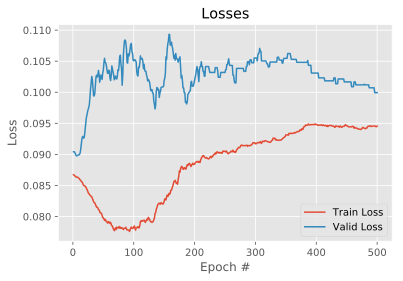

In [48]:
epoch_ticks = range(1, num_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.show()